### Libs import

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import * 
from sklearn.preprocessing import * 
import xgboost as xgb
from sklearn.decomposition import PCA, KernelPCA
# from sklearn.manifold import TSNE
import scipy
from sklearn.svm import SVC
import shap

In [ ]:
import tensorflow as tf

# A. Exploratory Data Analysis

### AA. Features

In [ ]:
# # Loading Data
# X_train = np.load('...')
# X_test = np.load('...')
# y_train = np.load('...')
# y_test = np.load('...')

In [ ]:
# Checking input data shapes
# X_train.shape, X_test.shape

### What we observe: 
- A 3D tensor containing observations for 128 seconds receieved from 9 sensors for each object.
- Number of objects (train) = 7 352, number of objects (test) = 2947.  
- In order to perform a classification task, it is better to get rid of the **third** dimension. As long as one of the dimensions of our input data's tensor is arrays of data unit for 128 seconds, probably, we do not need to feed the model with all 128 sec observations and can reduce this data to its in-group aggregation metrics - mean/median/std, etc. **Thus**, we will supposedly have train and test input tensors of (7352,9) and (2947, 9) respectively.
- In order to check which aggregation metric it is better to use, let's calculate variation coefficients for each group of 128 data units registered from each sernsor for each object

### Feature Enginnering

In [ ]:
# First of all, let's swap (reshape) our input tensor into (n, 9, 128) 
# to calculate descriptive statistics for SECONDS dimension observations for each sensor

# X_train_swapped = np.swapaxes(X_train, 1, 2)
# X_test_swapped = np.swapaxes(X_test, 1, 2)

In [ ]:
X_train_swapped.shape, X_test_swapped.shape

((7352, 9, 128), (2947, 9, 128))

### Visual representation of data semantics 

In [ ]:
# Variance Coefficient Calculation Function 
def var_coeff_calculation(arr = None):
    """Onece max and min variation coefficients are more than 33%, we can't convolute data to its mean
       It is better to use either std or median"""
    mean_s = np.array(arr).mean()
    std_s = np.array(arr).std()
    return (std_s, mean_s, std_s/mean_s) if mean_s != 0 else (std_s, mean_s, 0)

In [ ]:
# Let us calculate & check max and min of variation coefficients only for train data 
# - if it's not high (<33%),we'll perform the same procedure for the test sample

var_coeff_array_sensors = []
for lev_1 in X_train_swapped: 
    for lev_2 in lev_1: 
        var_coeff_array_sensors.append(var_coeff_calculation(lev_2))

In [ ]:
# Let us check if our variation coefficient array's dim matches 9*7352
len(var_coeff_array_sensors) == 9*7352

True

In [ ]:
ar_sort = sorted(var_coeff_array_sensors, key = lambda x: x[2]) # Sorting VarCoeff array

In [6]:
# Let us derive max and min variation coefficients throughout the whole train sample:
# ar_sort[0], ar_sort[-1]

### A short after-analysis conclusion
- Min & max variation coefficient values for the in-group obs for 7352 objects from 9 sensors - **m** and **n** respectively. These values are extremely high, so we are not supposed to use mean values for the third dimension. 
- At the same time, it can be relevant and wise to use **aggregative statistics** as features for future models, because we have to deal with numerical data which is obviously *homogeneously distributed* (the same data from equally functioning sensors)

<hr>

## Feature Engineering

### Convolution fuctions transforming goups of data units to their aggregative statistics

In [ ]:
# Relative descriptive statistics
def replace_dim_vc(_3dtensor, func1, func2):
    new_tensor = np.ones(shape = (_3dtensor.shape[0], _3dtensor.shape[1]))
    for i in range(0, _3dtensor.shape[0], 1): 
        for k in range(0, _3dtensor.shape[1], 1):
            new_tensor[i,k] = func1(_3dtensor[i,k]) / func2(_3dtensor[i,k]) if func2(_3dtensor[i,k]) != 0 else 0
    assert new_tensor.shape[0]*new_tensor.shape[1] == _3dtensor.shape[0]*_3dtensor.shape[1]
    return new_tensor

In [ ]:
# Aggregative function application
def replace_dim_f(_3dtensor, func):
    """func parameter takes a reference to the aggregate function to be used here"""
    new_tensor = np.ones(shape = (_3dtensor.shape[0], _3dtensor.shape[1]))
    for i in range(0, _3dtensor.shape[0], 1): 
        for k in range(0, _3dtensor.shape[1], 1):
            new_tensor[i,k] =  func(_3dtensor[i,k]) # Aggregation function application
    assert new_tensor.shape[0]*new_tensor.shape[1] == _3dtensor.shape[0]*_3dtensor.shape[1]
    return new_tensor

### Applying def replace_dim_median() to our train and test data

#### To median

In [ ]:
X_train_median = replace_dim_f(X_train_swapped, func = np.median)
X_test_median = replace_dim_f(X_test_swapped, func = np.median)

#### To mean

In [ ]:
X_train_mean = replace_dim_f(X_train_swapped, func = np.mean)
X_test_mean = replace_dim_f(X_test_swapped, func = np.mean)

#### To range of values

In [ ]:
X_train_ptp = replace_dim_f(X_train_swapped, func = np.ptp)
X_test_ptp = replace_dim_f(X_test_swapped, func = np.ptp)

#### To STD

In [ ]:
X_train_std = replace_dim_f(X_train_swapped, func = np.std )
X_test_std = replace_dim_f(X_test_swapped, func = np.std)

#### To Reverse Variation Coefficient & Oscilation Coefficient

In [ ]:
X_train_vc = replace_dim_vc(X_train_swapped, func1 = np.mean, func2 = np.std)
X_test_vc = replace_dim_vc(X_test_swapped, func1 = np.mean, func2 = np.std)

In [ ]:
X_train_oc = replace_dim_vc(X_train_swapped, func1 = np.mean, func2 = np.ptp)
X_test_oc = replace_dim_vc(X_test_swapped, func1 = np.mean, func2 = np.ptp)

#### To Kurtosis (4th moment)

In [ ]:
X_train_kurt = replace_dim_f(X_train_swapped, func = scipy.stats.kurtosis)
X_test_kurt = replace_dim_f(X_test_swapped, func = scipy.stats.kurtosis)

#### To Skew (3rd moment)

In [ ]:
X_train_skew = replace_dim_f(X_train_swapped, scipy.stats.skew)
X_test_skew = replace_dim_f(X_test_swapped, scipy.stats.skew)

#### To min & max - optional

In [ ]:
X_train_min = replace_dim_f(X_train_swapped, np.min)
X_test_min = replace_dim_f(X_test_swapped, np.min)

In [ ]:
X_train_max = replace_dim_f(X_train_swapped, np.max)
X_test_max = replace_dim_f(X_test_swapped, np.max)

#### To MUL - optional

In [ ]:
X_train_mul_1 = np.array([X_train_vc[:, i] * X_train_std[:, i+1] for i in range(0, X_train_std.shape[1]-2, 1)]).T 
X_test_mul_1 = np.array([X_test_vc[:, i] * X_test_std[:, i+1] for i in range(0, X_test_std.shape[1]-2, 1)]).T 

<hr>

Esperimentally, we have managed to achieve the best quality metric values for all the algs (except of the one of CNN) _through feature generation -  having extracted median, std, reverse variation & oscillation coefficient, kurtosis and skew values for the 128 observations coming from 9 sensors for every object_ as our features (45 features in total) 

In [ ]:
X_train_f = np.concatenate((X_train_median, X_train_std, X_train_vc, X_train_kurt, X_train_skew), axis = 1)
X_test_f = np.concatenate((X_test_median, X_test_std, X_test_vc, X_test_kurt, X_test_skew), axis = 1)

#### Brief look at the data

In [ ]:
# pd.DataFrame(X_train_f).tail()

#### Some plots for our median data

Mean for in-group median values is close to 0.0


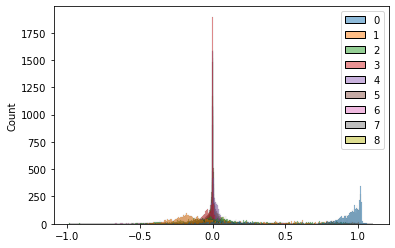

In [ ]:
# Histplot for X_train_new_sensors
sns.histplot(X_train_median)
print('Mean for in-group median values is close to 0.0')
plt.show()

Mean for in-group median values is close to 0.0


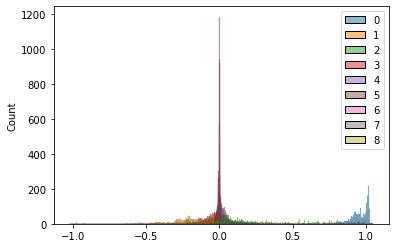

In [ ]:
# Histplot for X_test_new_sensors
sns.histplot(X_test_median)
print('Mean for in-group median values is close to 0.0')
plt.show()

<hr>

### AB. Target

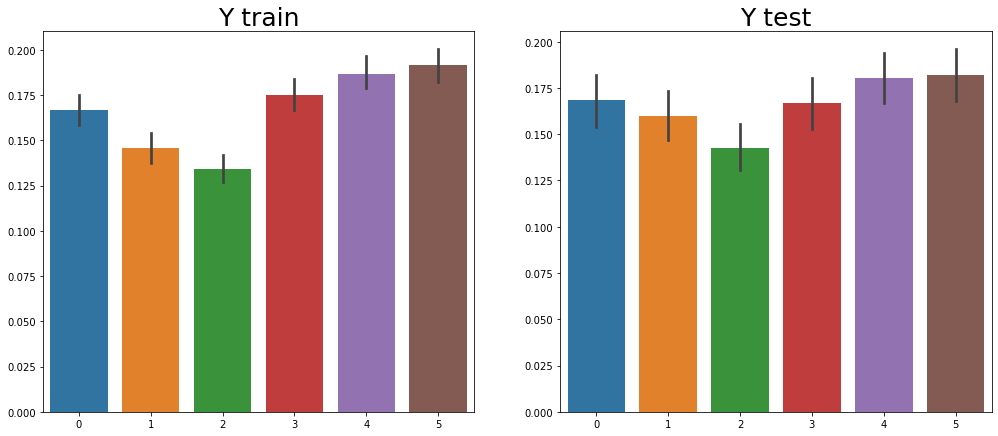

In [ ]:
# Checking if there is any sign of class disbalance in target variables (y_train, y _test)
fig1, ax1 = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
for piece_of_data in [(ax1[0], y_train, 'Y train'), (ax1[1], y_test, 'Y test')]:
    df_Y = pd.DataFrame(piece_of_data[1])
    sns.barplot(ax = piece_of_data[0], 
                data = df_Y)
    piece_of_data[0].set_title(piece_of_data[2], size = 25)

**Number of observations**: 
- with class value 5 - 20% 
- with class value 4 - 18% 
- with class value 3 - 17,5%
- with class value 2 - 13%
- with class value 1 - 15% 
- with class value 0 - 16% 

**Variation coefficient:** 14,82% < 33% => no strong class disbalance

<hr>

### Transforming Y: one-hot encoded -> multinominal vectors

In [ ]:
y_train_vector = np.array([int(np.where(a == 1)[0]) for a in y_train])
y_test_vector = np.array([int(np.where(b == 1)[0]) for b in y_test])

<hr>

# B. ML algorithms implementation

- XGBoosting 
- Dense Neural Network 
- Random Forest Classifier
- Сonvolutional Neural Network

### B-1. XGBoost

In [ ]:
boosting_model = xgb.XGBClassifier(reg_lambda = 0.2, 
                                          max_depth = 6, 
                                          n_estimators = 90, 
                                          learning_rate = 0.27).fit(X_train_f, y_train_vector)

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:18:03] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### Classification report

In [ ]:
print(f'Test sample metrics:\n{classification_report(y_test_vector, boosting_model.predict(X_test_f))}')

Test sample metrics:
              precision    recall  f1-score   support

           0       0.73      0.74      0.74       496
           1       0.81      0.72      0.76       471
           2       0.78      0.87      0.82       420
           3       0.88      0.83      0.86       491
           4       0.86      0.90      0.88       532
           5       1.00      1.00      1.00       537

    accuracy                           0.85      2947
   macro avg       0.84      0.84      0.84      2947
weighted avg       0.85      0.85      0.85      2947



In [ ]:
roc_auc_train_xgb = roc_auc_score(y_train_vector, boosting_model.predict_proba(X_train_f), multi_class = 'ovr')
roc_auc_test_xgb = roc_auc_score(y_test_vector, boosting_model.predict_proba(X_test_f), multi_class = 'ovr')

In [ ]:
roc_auc_train_xgb, roc_auc_test_xgb # slight overfitting

(1.0, 0.982462599582727)

<hr>

<hr>

### B-2. Dense Neural Network

In [ ]:
# Neural net architecture
neural_net_model = tf.keras.models.Sequential([tf.keras.Input(shape = (54,)),
                                              tf.keras.layers.Dense(229, activation = 'relu', 
                                                                    bias_initializer = 'zeros'), 
                                               tf.keras.layers.Dense(6, activation = 'softmax')])

In [ ]:
neural_net_model.compile(optimizer = 'adam', 
                        loss = 'categorical_crossentropy', 
                        metrics = ['Precision', 'Recall'])

In [ ]:
# X_train_nn = np.concatenate((X_train_f, X_train_25), axis = 1)
# X_test_nn = np.concatenate((X_test_f, X_test_25), axis = 1)

In [ ]:
neural_net_model.fit(X_train_f, y_train, epochs = 18)

Epoch 1/18
230/230 [==============================] - 0s 1ms/step - loss: 1.0578 - precision: 0.8580 - recall: 0.6968
Epoch 2/18
230/230 [==============================] - 0s 1ms/step - loss: 0.3366 - precision: 0.8978 - recall: 0.8701
Epoch 3/18
230/230 [==============================] - 0s 1ms/step - loss: 0.3005 - precision: 0.9107 - recall: 0.8961
Epoch 4/18
230/230 [==============================] - 0s 1ms/step - loss: 0.2874 - precision: 0.9131 - recall: 0.9037
Epoch 5/18
230/230 [==============================] - 0s 1ms/step - loss: 0.2418 - precision: 0.9266 - recall: 0.9200
Epoch 6/18
230/230 [==============================] - 0s 1ms/step - loss: 0.2511 - precision: 0.9216 - recall: 0.9163
Epoch 7/18
230/230 [==============================] - 0s 1ms/step - loss: 0.2479 - precision: 0.9282 - recall: 0.9251
Epoch 8/18
230/230 [==============================] - 0s 1ms/step - loss: 0.2401 - precision: 0.9333 - recall: 0.9305
Epoch 9/18
230/230 [==============================] - 0s

In [ ]:
predictions_neural_net_train = neural_net_model.predict_classes(X_train_f)
predictions_neural_net_test = neural_net_model.predict_classes(X_test_f)

#### Classification report

In [ ]:
print(f'Test sample predictions:\n{classification_report(y_test_vector, predictions_neural_net_test)}')

Test sample predictions:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       496
           1       0.85      0.73      0.79       471
           2       0.83      0.95      0.88       420
           3       0.90      0.62      0.73       491
           4       0.74      0.93      0.82       532
           5       0.99      0.97      0.98       537

    accuracy                           0.84      2947
   macro avg       0.85      0.84      0.84      2947
weighted avg       0.85      0.84      0.84      2947



In [ ]:
roc_auc_train_std_nn = roc_auc_score(y_train_vector, neural_net_model.predict(X_train_f), multi_class = 'ovr')
roc_auc_test_std_nn = roc_auc_score(y_test_vector, neural_net_model.predict(X_test_f), multi_class = 'ovr')

In [ ]:
roc_auc_train_std_nn, roc_auc_test_std_nn

(0.996643146081599, 0.9742618146380924)

<hr>

### B-3. Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
nbc_model = GaussianNB().fit(X_train_f, y_train_vector)

#### Classification report

In [ ]:
print(f'Test sample metrics:\n{classification_report(y_test_vector, nbc_model.predict(X_test_f))}')

Test sample metrics:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       496
           1       0.85      0.79      0.82       471
           2       0.95      0.83      0.88       420
           3       0.90      0.54      0.68       491
           4       0.69      0.93      0.80       532
           5       0.98      1.00      0.99       537

    accuracy                           0.84      2947
   macro avg       0.86      0.83      0.83      2947
weighted avg       0.85      0.84      0.83      2947



In [ ]:
roc_auc_train_median_nb = roc_auc_score(y_train_vector, nbc_model.predict_proba(X_train_f), multi_class = 'ovr')
roc_auc_test_median_nb = roc_auc_score(y_test_vector, nbc_model.predict_proba(X_test_f), multi_class = 'ovr')

roc_auc_train_median_nb, roc_auc_test_median_nb

(0.9839805741711459, 0.9824641127496577)

<hr>

### B-4. Random Forest Classifier

Experimentally, we have found out it is better to modify input data specifically for RFC by adding ranges of values for 128 data units of each sensor

In [ ]:
X_train_rfc = np.concatenate((X_train_f, X_train_ptp), axis = 1)
X_test_rfc = np.concatenate((X_test_f, X_test_ptp), axis = 1)

In [ ]:
rfc_model = RandomForestClassifier().fit(X_train_rfc, y_train_vector)

#### Classification report

In [ ]:
print(f'Test sample metrics:\n{classification_report(y_test_vector, rfc_model.predict(X_test_rfc))}')

Test sample metrics:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       496
           1       0.74      0.79      0.76       471
           2       0.91      0.86      0.88       420
           3       0.88      0.87      0.87       491
           4       0.88      0.89      0.88       532
           5       1.00      1.00      1.00       537

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947



In [ ]:
roc_auc_train_median_rfc = roc_auc_score(y_train_vector, rfc_model.predict_proba(X_train_rfc), multi_class = 'ovr')
roc_auc_test_median_rfc = roc_auc_score(y_test_vector, rfc_model.predict_proba(X_test_rfc), multi_class = 'ovr')

In [ ]:
roc_auc_train_median_rfc, roc_auc_test_median_rfc # slight overfitting

(1.0, 0.9835968825486604)

### B-5 (Winner) Convolutional-1D Neural Network -here we didn't need to provide any feature engineering as 1D-Conv NN can efficiently deal with 3D tensors (exactly like our input data tensor)

#### CNN architecture

In [ ]:
model_CNN = tf.keras.Sequential([tf.keras.Input(shape = (9, 128)), 
                                       tf.keras.layers.Conv1D(kernel_size = 3, filters = 5000, activation = 'relu'), 
                                       tf.keras.layers.Conv1D(kernel_size = 3, filters = 5, activation = 'relu'),
                                       tf.keras.layers.Flatten(), 
                                       tf.keras.layers.Dense(229, activation = 'relu', bias_initializer = 'zeros'), 
                                       tf.keras.layers.Dense(6, activation = 'softmax')])

#### Compilation 

In [ ]:
model_CNN.compile(optimizer = 'adam', 
                  loss = 'categorical_crossentropy', 
                  metrics = ['Precision', 'Recall'])

#### Fitting - we provide our swapped 3d tensor as input

In [ ]:
model_CNN.fit(X_train_swapped, y_train, epochs = 20)

Epoch 1/20
230/230 [==============================] - 17s 73ms/step - loss: 0.0447 - precision: 0.9860 - recall: 0.9857
Epoch 2/20
230/230 [==============================] - 16s 68ms/step - loss: 0.0486 - precision: 0.9860 - recall: 0.9860
Epoch 3/20
230/230 [==============================] - 16s 71ms/step - loss: 0.0322 - precision: 0.9910 - recall: 0.9909
Epoch 4/20
230/230 [==============================] - 16s 68ms/step - loss: 0.0130 - precision: 0.9952 - recall: 0.9952
Epoch 5/20
230/230 [==============================] - 18s 77ms/step - loss: 0.0810 - precision: 0.9812 - recall: 0.9808
Epoch 6/20
230/230 [==============================] - 17s 75ms/step - loss: 0.0460 - precision: 0.9856 - recall: 0.9856
Epoch 7/20
230/230 [==============================] - 17s 73ms/step - loss: 0.0194 - precision: 0.9939 - recall: 0.9939
Epoch 8/20
230/230 [==============================] - 18s 77ms/step - loss: 0.0039 - precision: 0.9993 - recall: 0.9993
Epoch 9/20
230/230 [====================

#### Classification report

In [ ]:
print(f'Test sample predictions:\n{classification_report(y_test_vector, model_CNN.predict_classes(X_test_swapped))}')

Test sample predictions:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.92      0.93      0.93       471
           2       0.89      0.95      0.92       420
           3       0.93      0.81      0.87       491
           4       0.81      0.94      0.87       532
           5       0.99      0.95      0.97       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



In [ ]:
roc_auc_train_cnn = roc_auc_score(y_train_vector, model_CNN.predict(X_train_swapped), multi_class = 'ovr')
roc_auc_test_cnn = roc_auc_score(y_test_vector, model_CNN.predict(X_test_swapped), multi_class = 'ovr')
roc_auc_train_cnn, roc_auc_test_cnn

(1.0, 0.9751168843964385)

<hr>

### Results 
As we can see, the best solution for the problem presented is a 1D-CNN model. It's been possible to reach the scores of 92% for each metric taken into consideration